In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [2]:
# Smaller data frame of 50,000 rows
df = pd.read_csv('sampled_data_50k.csv')
print(df.shape)
df.describe()

(50000, 99)


,activity_year,derived_msa-md,county_code,census_tract,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
count,50000.0,50000.000000,48996.000000,4.888300e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,...,1587.000000,266.000000,29.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2019.0,36487.085260,27004.907809,2.698962e+10,2.543580,5.710460,1.974780,1.373400,13.799820,1.12194,...,4.167612,4.902256,5.896552,5612.952940,31.306889,76940.078000,112.438720,1443.222080,1960.469980,34.598920
std,0.0,23661.882417,16580.158488,1.657918e+10,1.893466,17.161748,0.156794,0.704345,14.751788,0.32722,...,2.660416,2.691327,2.540315,3202.580495,25.826997,20203.776068,45.176299,880.041849,1099.011731,18.350049
min,2019.0,0.000000,1001.000000,1.001020e+09,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019.0,19740.000000,12069.000000,1.206105e+10,1.000000,0.000000,2.000000,1.000000,1.000000,1.00000,...,2.000000,3.000000,5.000000,3759.750000,10.780000,66900.000000,86.000000,901.000000,1299.000000,21.000000
50%,2019.0,33874.000000,26099.000000,2.609925e+10,1.000000,0.000000,2.000000,1.000000,2.000000,1.00000,...,3.000000,5.000000,6.000000,5116.000000,23.430000,75600.000000,108.000000,1313.000000,1793.000000,33.000000
75%,2019.0,41740.000000,42017.000000,4.201301e+10,4.000000,2.000000,2.000000,2.000000,31.000000,1.00000,...,6.000000,6.750000,9.000000,6783.250000,45.620000,86100.000000,135.000000,1812.000000,2414.000000,46.000000
max,2019.0,99999.000000,72153.000000,7.215375e+10,8.000000,72.000000,2.000000,4.000000,32.000000,2.00000,...,9.000000,9.000000,9.000000,53812.000000,100.000000,151000.000000,468.000000,19529.000000,25391.000000,76.000000


### First looking at NA values by row.

In [3]:
# Creating a column that indicates the number of NA values for each observation
df['NA_count'] = df.isnull().sum(axis=1)

# Getting the summary statistics for NA_count column
df['NA_count'].describe()

count    50000.000000
mean        31.464100
std          3.475571
min         21.000000
25%         29.000000
50%         31.000000
75%         34.000000
max         43.000000
Name: NA_count, dtype: float64

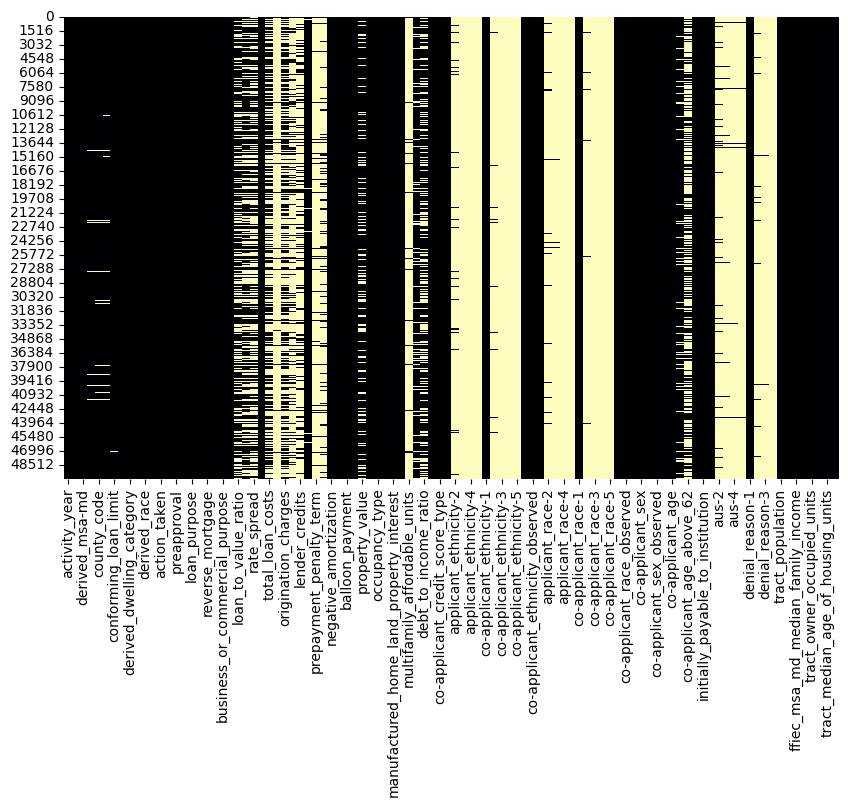

In [4]:
# Plotting a heatmap of NA values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='magma')
plt.show()

In [5]:
# Compute the percentage of NA values for each column
na_percent = df.isna().mean() * 100

# Print columns with NA values and their percentages
for column, percent in na_percent.items():
    if percent > 0:
        print(f'{column} has {percent:.2f}% NA values.')

state_code has 1.11% NA values.
county_code has 2.01% NA values.
census_tract has 2.23% NA values.
conforming_loan_limit has 0.43% NA values.
loan_to_value_ratio has 33.73% NA values.
interest_rate has 30.74% NA values.
rate_spread has 47.77% NA values.
total_loan_costs has 44.69% NA values.
total_points_and_fees has 96.95% NA values.
origination_charges has 44.71% NA values.
discount_points has 79.00% NA values.
lender_credits has 76.84% NA values.
loan_term has 1.28% NA values.
prepayment_penalty_term has 94.11% NA values.
intro_rate_period has 83.29% NA values.
property_value has 19.18% NA values.
multifamily_affordable_units has 97.21% NA values.
income has 12.75% NA values.
debt_to_income_ratio has 33.97% NA values.
applicant_ethnicity-1 has 0.04% NA values.
applicant_ethnicity-2 has 95.68% NA values.
applicant_ethnicity-3 has 99.96% NA values.
applicant_ethnicity-4 has 100.00% NA values.
applicant_ethnicity-5 has 100.00% NA values.
co-applicant_ethnicity-1 has 0.01% NA values.
co

## Using KNN to impute missing NA values

In [6]:
# KNN imputer does not work with strings.
# Finding which columns are object data types
string_columns = df.select_dtypes(include=['object']).columns
print(string_columns)

Index(['lei', 'state_code', 'conforming_loan_limit',
       'derived_loan_product_type', 'derived_dwelling_category',
       'derived_ethnicity', 'derived_race', 'derived_sex',
       'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'total_loan_costs', 'total_points_and_fees', 'origination_charges',
       'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'property_value',
       'total_units', 'multifamily_affordable_units', 'debt_to_income_ratio',
       'applicant_age', 'co-applicant_age', 'applicant_age_above_62',
       'co-applicant_age_above_62'],
      dtype='object')


In [7]:
# Some columns are being stored as strings because they have an 'exempt' value.

# Finding columns with exempt
columns_with_exempt = []

# Iterate through all columns
for col in df.columns:
    # Check if 'Exempt' is in the column
    if (df[col] == 'Exempt').any():
        columns_with_exempt.append(col)


columns_with_exempt

['loan_to_value_ratio',
 'interest_rate',
 'rate_spread',
 'total_loan_costs',
 'total_points_and_fees',
 'origination_charges',
 'discount_points',
 'lender_credits',
 'loan_term',
 'prepayment_penalty_term',
 'intro_rate_period',
 'property_value',
 'multifamily_affordable_units',
 'debt_to_income_ratio']

In [8]:
# Replacing the word 'Exempt" with NA values and changing the column to numeric

# Iterate through the specified columns
for col in columns_with_exempt:
    # Replace the word 'Exempt' with NA
    df[col] = df[col].replace('Exempt', np.nan)
    
    # Convert the column to a numeric data type
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [9]:
# Getting the remaining strings 
string_columns = df.select_dtypes(include=['object']).columns
string_df = df[string_columns]
print(string_columns)

# Dropping these columns
df = df.drop(columns = string_columns)

Index(['lei', 'state_code', 'conforming_loan_limit',
       'derived_loan_product_type', 'derived_dwelling_category',
       'derived_ethnicity', 'derived_race', 'derived_sex', 'total_units',
       'applicant_age', 'co-applicant_age', 'applicant_age_above_62',
       'co-applicant_age_above_62'],
      dtype='object')


In [10]:
# # Getting the columns that are strings but did not have 'Exempt' values.
# drop_columns = list(set(string_columns.tolist()) - set(columns_with_exempt))

# # Dropping these columns
# df = df.drop(columns = drop_columns)

In [11]:
# KNN Imputer does not work with columns that are 100% NA values. 
# Finding these columns and dropping them.
na_percent = df.isna().mean()
df = df.drop(columns = na_percent[na_percent > .99].index.tolist()) 

In [12]:
# KNN imputer only works on numeric data. We will separate the 

In [13]:
# With the non-numeric columns and 100% NAs out of the way, we can begin KNN imputation
KNN_imputer = KNNImputer(n_neighbors=4)

new_df = df.select_dtypes(include=[np.number])

new_df = pd.DataFrame(KNN_imputer.fit_transform(new_df), columns=new_df.columns)

In [14]:
# Looking at the new data frame which should have no NA values

print("Number of NA values:", new_df.isna().sum().sum())

new_df.head(10)

Number of NA values: 0


,activity_year,derived_msa-md,county_code,census_tract,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,...,denial_reason-1,denial_reason-2,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,NA_count
0,2019.0,45104.0,53053.0,5.305306e+10,3.0,0.0,2.0,1.0,31.0,1.0,...,1.0,3.50,7353.0,47.53,80200.0,72.0,1390.0,2462.0,49.0,34.0
1,2019.0,99999.0,6109.0,6.109001e+09,1.0,6.0,2.0,1.0,1.0,1.0,...,10.0,6.00,3735.0,24.47,64800.0,69.0,572.0,1605.0,47.0,29.0
2,2019.0,19740.0,8005.0,8.005007e+09,3.0,0.0,2.0,1.0,1.0,1.0,...,1.0,5.00,4032.0,15.85,92800.0,136.0,1314.0,1479.0,40.0,33.0
3,2019.0,41740.0,6073.0,6.073017e+09,1.0,3.0,2.0,1.0,1.0,1.0,...,10.0,6.00,9067.0,26.17,86300.0,211.0,2618.0,3446.0,14.0,30.0
4,2019.0,10740.0,35057.0,3.505796e+10,5.0,0.0,2.0,2.0,1.0,1.0,...,10.0,2.00,3375.0,49.90,65700.0,73.0,942.0,1543.0,31.0,36.0
5,2019.0,19430.0,39113.0,3.911308e+10,1.0,8.0,2.0,1.0,1.0,1.0,...,10.0,2.75,6229.0,75.33,70600.0,56.0,1247.0,2143.0,49.0,29.0
6,2019.0,35004.0,36103.0,3.610316e+10,6.0,71.0,2.0,1.0,1.0,1.0,...,10.0,4.00,7179.0,33.79,124000.0,69.0,1390.0,1822.0,39.0,33.0
7,2019.0,36084.0,6013.0,6.013345e+09,4.0,0.0,2.0,1.0,1.0,1.0,...,10.0,3.75,7267.0,48.62,111700.0,158.0,2298.0,2597.0,27.0,34.0
8,2019.0,47664.0,26099.0,2.609923e+10,4.0,0.0,2.0,1.0,31.0,1.0,...,10.0,3.00,4449.0,15.31,88200.0,77.0,1131.0,1518.0,36.0,36.0
9,2019.0,35084.0,34037.0,3.403737e+10,1.0,1.0,2.0,1.0,32.0,1.0,...,10.0,4.75,5056.0,4.37,98600.0,117.0,1939.0,2366.0,38.0,30.0


In [15]:
# Re-appending the strings from earlier
final_df = pd.concat([new_df, string_df], axis=1)
final_df = final_df.drop(columns='NA_count')
print(final_df.shape)
final_df.columns

(50000, 81)


Index(['activity_year', 'derived_msa-md', 'county_code', 'census_tract',
       'action_taken', 'purchaser_type', 'preapproval', 'loan_type',
       'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'origination_charges',
       'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'income',
       'debt_to_income_ratio', 'applicant_credit_score_type',
       'co-applicant_credit_score_type', 'applicant_ethnicity-1',
       'applicant_ethnicity-2', 'co-applicant_ethnicity-1',
    

In [16]:
# Saving the data set
final_df.to_csv('na_filled_df.csv', index=False)